# Binary Classification of Insurance Cross Selling

#### Playground Series - Season 4, Episode 7

## Model Blend with CatBoost, LightGBM, and XGBoost.

**Author:** Paulo Araya-Santiago

Welcome to my comprehensive notebook for the Kaggle Playground Series:Binary Classification of Insurance Cross Selling. This notebook demonstrates my end-to-end workflow, from data exploration and preprocessing to feature engineering and model tuning. The goal is to build a robust model that accurately predicts insurance responses. This particular version of this notebook is meant to be ran in Kaggle and displayed for the competition.

## Preliminary Tests and Findings

This notebook is the culmination of the creation of at least 50 different notebooks for this competition. As of the creation of this version I still haven't been able to obtain my ideal score, but I decided to share my favorite parts of my work. I started by testing the dataset on different models with only the necessary transformations done to the features. XGBoost and LightGBM stood out from the start. I settled on trying to perfect the LightGBM model by running it through hundreds of iterations across multiple weeks on OPTUNA. When I was satisfied with the validation scores, I submitted it to the competition and the results were lackluster. This led me to take a deep dive into other notebooks scoring high in the competition (all of which are referenced below). After trying all sorts of feature engineering techniques, through testing and research I found that the dataset worked best with the addition of a few interaction features. I later found a notebook along the highest scoring ones that created a blend out of other people's submissions. I found this interesting and decided to concuct my own blend. At first the blend created an averaged prediction through stratified KFolds but it was too computationally expensive, so I settled with three straight forward models.

## Early Explorations

I first started with a little exploratory data analysis (EDA) and basic data processing. The data comes pretty clean, but the dataset is MASSIVE. The largest I had worked with previously had been around 70k rows, but this one had 11 million. Not many columns though. Most columns were fairly easy to handle except for `Region_Code` and `Policy_Sales_Channel`. I treated those by binning them into a rare category due to the heavy imbalance towards some values. Otherwise, everything was treated pretty basically.

I made some basic EDA graphs to explore the data, using some base models to understand feature importances. Later, I discovered the magic of KLIB from another notebook: [Optuna XGBoost KLIB Notebook](https://www.kaggle.com/code/suvroo/ps4e7-optuna-xgboost-klib), which taught me a thing or two about cleaning the data easily with KLIB, and how to keep track of hyperparameter studies with Optuna and some of its also amazing graphs.

At first, I applied the basic preprocessing steps necessary to run the dataset efficiently in the models I was using. Also incorporating some downcasting to the workflow so that the model would work more efficiently. I tried applying some additional transformations to the data like removing outliers, creating rare categories for feature values with low counts, and creating KMEANS cluster feature. I also tested borrowed feature interactions from other notebooks and created my own. After possibly hundreds of tests, I settled on a combination of my own feature interactions and a set of feature interactions from [this Kaggle notebook](https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution).

## Libraries Import
In this section, we import all necessary libraries required for data manipulation, visualization, model building, and evaluation.

In [5]:
%%capture
!pip install klib

In [6]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from datetime import datetime
import klib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

from datetime import datetime

warnings.filterwarnings("ignore")

## Data Loading
Here, we load the training dataset. This dataset will be used for all subsequent data processing and model training steps. This dataset was created artificially for the Kaggle Playground Series S4E7, based on [this set](https://www.kaggle.com/datasets/annantkumarsingh/health-insurance-cross-sell-prediction-data). For EDA, I'll use only a sample.

In [7]:
# Paths to datasets
# train_path = "/kaggle/input/playground-series-s4e7/train.csv"
# test_path = "/kaggle/input/playground-series-s4e7/test.csv"

# # Paths to datasets
train_path = r"C:\Users\paulo\OneDrive\Documents\kaggle_competition_2_datasets\train.csv"
test_path = r"C:\Users\paulo\OneDrive\Documents\kaggle_competition_2_datasets\test.csv"

eda_df = pd.read_csv(train_path).sample(frac=0.005)

### Displaying Sampled Data
After performing sampling, we display the first few rows of the sampled dataset to understand its structure and verify the sampling process.

In [8]:
eda_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
7204480,7204480,Male,57,1,28.0,1,1-2 Year,No,29587.0,124.0,194,0
7799159,7799159,Female,38,1,28.0,0,> 2 Years,Yes,35768.0,124.0,128,0
11386901,11386901,Male,25,1,30.0,1,< 1 Year,No,24807.0,152.0,203,0
4101126,4101126,Male,29,1,3.0,1,< 1 Year,No,22602.0,152.0,73,0
3522773,3522773,Male,46,1,45.0,1,1-2 Year,No,37295.0,26.0,92,0


In [9]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57524 entries, 7204480 to 5295802
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    57524 non-null  int64  
 1   Gender                57524 non-null  object 
 2   Age                   57524 non-null  int64  
 3   Driving_License       57524 non-null  int64  
 4   Region_Code           57524 non-null  float64
 5   Previously_Insured    57524 non-null  int64  
 6   Vehicle_Age           57524 non-null  object 
 7   Vehicle_Damage        57524 non-null  object 
 8   Annual_Premium        57524 non-null  float64
 9   Policy_Sales_Channel  57524 non-null  float64
 10  Vintage               57524 non-null  int64  
 11  Response              57524 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 5.7+ MB


### Data Summary
We use the `describe` method to generate summary statistics for the numerical columns in the dataset. This provides insights into the central tendency, dispersion, and shape of the dataset’s distribution.


In [10]:
eda_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,5.752400e+04,57524.000000,57524.000000,57524.000000,57524.000000,57524.000000,57524.000000,57524.000000,57524.000000
mean,5.735440e+06,38.459304,0.998070,26.344813,0.460955,30437.118803,112.561922,163.885109,0.121723
std,3.321853e+06,15.064084,0.043886,12.960785,0.498478,16538.244696,53.958363,79.832323,0.326969
min,1.360000e+02,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,2.848022e+06,24.000000,1.000000,15.000000,0.000000,25250.000000,30.000000,99.000000,0.000000
50%,5.714874e+06,36.000000,1.000000,28.000000,0.000000,31865.000000,151.000000,165.000000,0.000000
75%,8.618219e+06,49.000000,1.000000,35.000000,1.000000,39460.000000,152.000000,232.000000,0.000000
max,1.150470e+07,83.000000,1.000000,52.000000,1.000000,459010.000000,163.000000,299.000000,1.000000


### Missing Values Check
It is essential to check for missing values in the dataset as they can affect the model performance. Here, we count the number of missing values in each column.



In [11]:
eda_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

### Initial Observations and Ideas

- **Gender, Driving_License, Regional_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Policy_Sales_Channel, and Response** are all categories. I will treat most of them as numerical columns for now, except for Gender, Vehicle_Age, Previously_Insured, and Vehicle_Damage, which I will turn into categories to use in KLIB's streamlined categorical plotting. From previous explorations, I know Driving_License only has 1 negative value, so I will drop it.
- I will later remap those four categories into numerical columns after EDA as part of the preprocessing for the model.
- I will MinMax scale Age and Vintage when standardizing because they have a reasonable range for this type of transformation.


# EDA

I turn some categories I want to plot into category dtype to be compatible with klib, they will automatically switch back to numeric during preprocessing.

In [12]:
# Convert specified columns to categorical
categorical_columns = ['Gender', 'Vehicle_Age', 'Previously_Insured']

for col in categorical_columns:
    eda_df[col] = eda_df[col].astype('category')

# Convert 'Previously_Insured' column to a categorical type with specific labels
eda_df['Previously_Insured'] = pd.Categorical(eda_df['Previously_Insured'], categories=[0, 1], ordered=True)
eda_df['Previously_Insured'] = eda_df['Previously_Insured'].cat.rename_categories(["Uninsured", "Insured"])


### Visualizing Data with KLIB
Using KLIB, we create categorical plots to visualize the distribution of categorical features in the dataset. This helps in understanding the balance of different categories within the dataset.

GridSpec(6, 4)

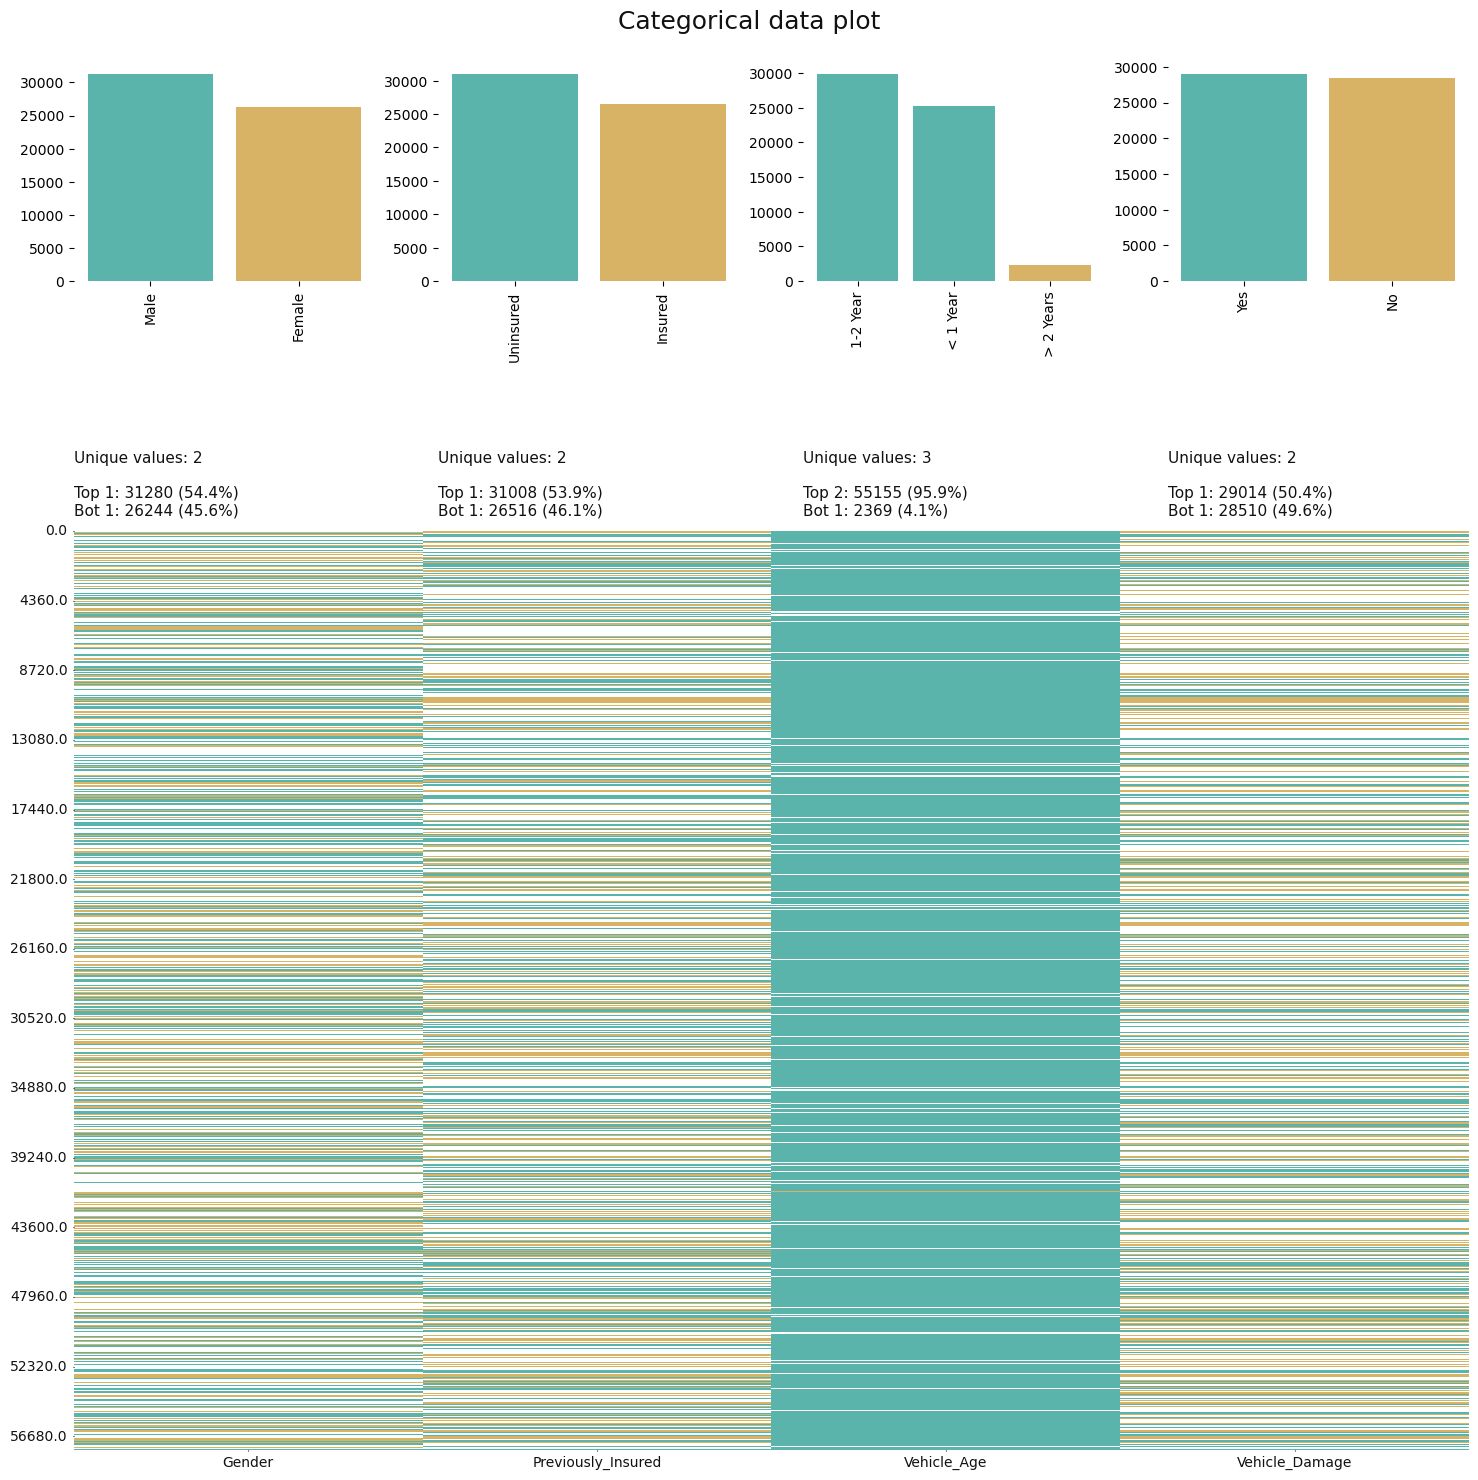

In [13]:
klib.cat_plot(eda_df)

### KLIB Cat Plot Explanation
The KLIB categorical plot is an interesting way of visualizing binary variables within a dataset. However, it doesn't translate too well with categorical variables having more than two possible values.


### Plotting Relationships

We create a custom function to plot the relationship between categorical variables and the target in a 2x2 single figure.


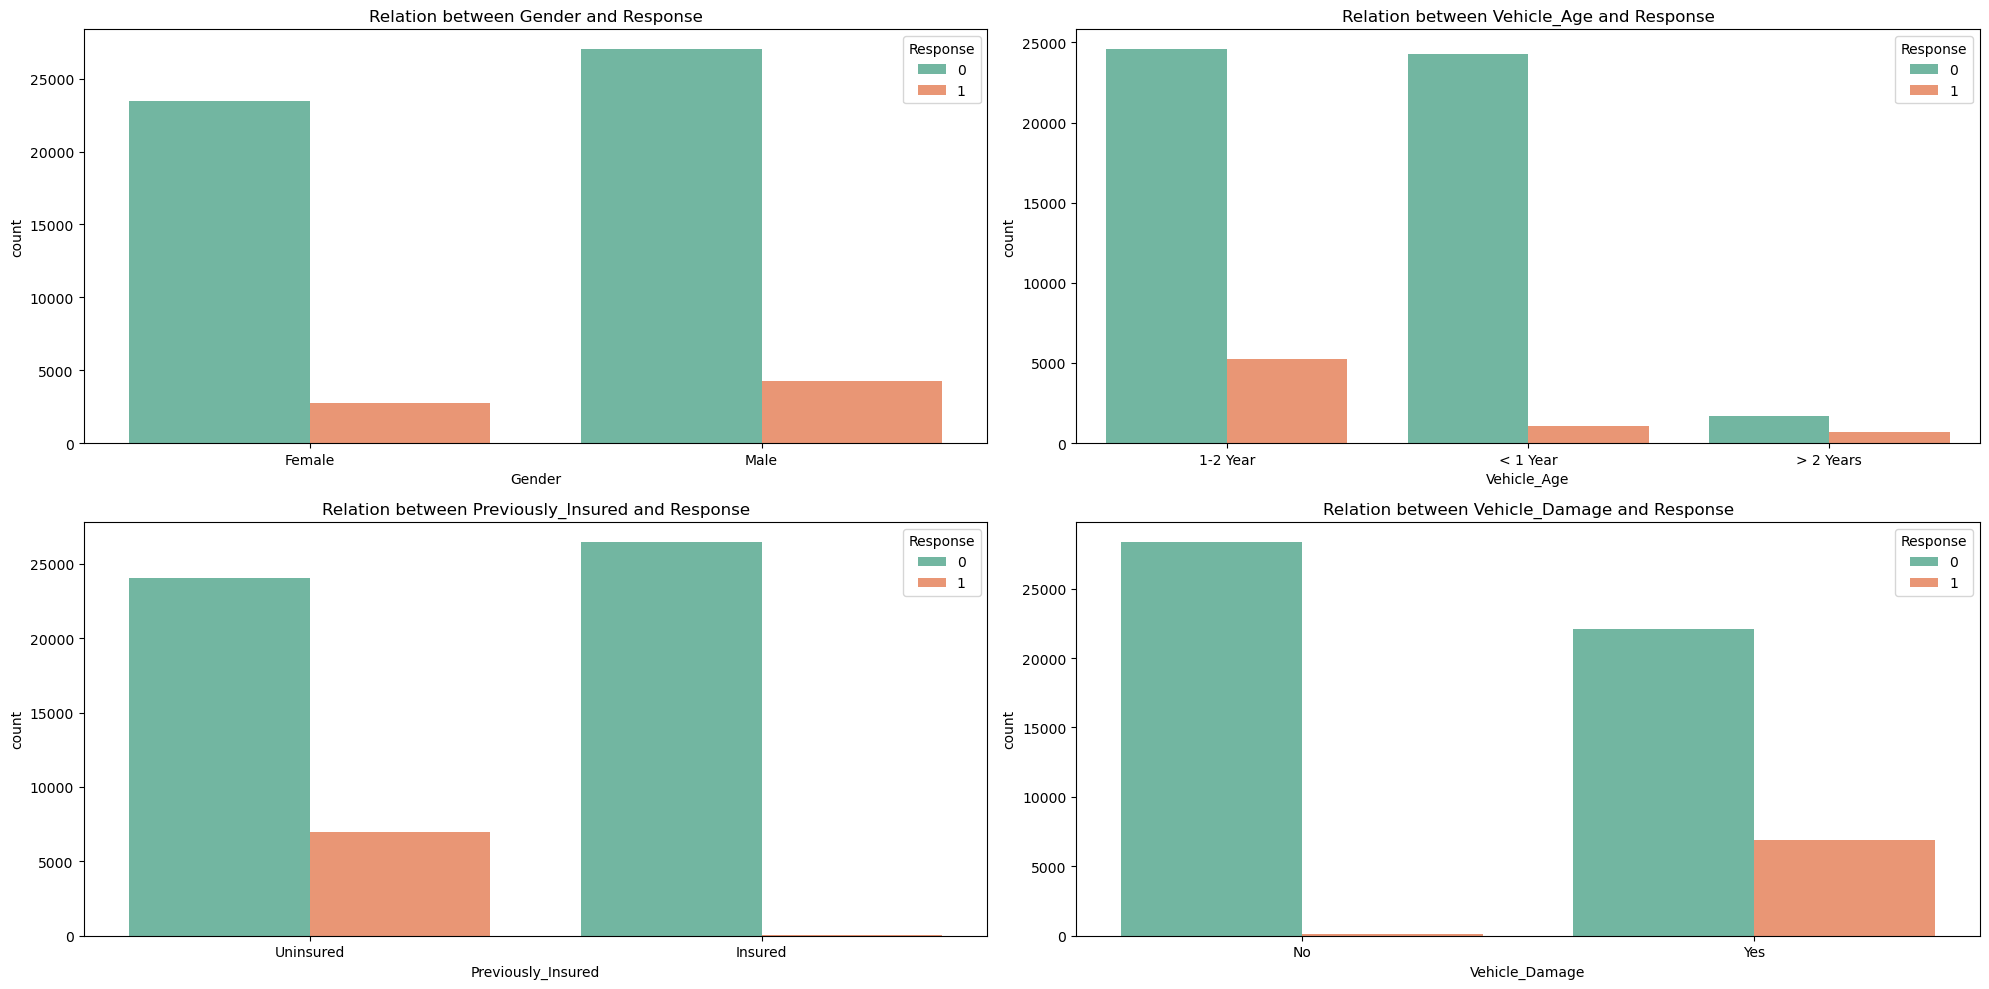

In [14]:
# Function to plot the relationship between categorical variables and the target in a 2x2 single figure
def plot_categorical_vs_target(df, cat_cols, target_col):
    num_plots = len(cat_cols)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    palette = ["#66c2a5", "#fc8d62"]  # Custom palette with exactly two colors

    for ax, col in zip(axes.flatten(), cat_cols):
        sns.countplot(data=df, x=col, hue=target_col, ax=ax, palette=palette)
        ax.set_title(f'Relation between {col} and {target_col}')

    plt.tight_layout()
    plt.show()

# Plot the relationships
categorical_columns = ['Gender', 'Vehicle_Age', 'Previously_Insured', 'Vehicle_Damage']
plot_categorical_vs_target(eda_df, categorical_columns, 'Response')


The binary categories were balanced for the most part. Gender's relation to the target doesn't tell us much knowing that there are slightly more Males to begin with. People with newer vehicles are much more likely to insure them. Naturally people that are already insured answered No (who knows if that was a no to switching providers as well). People with no vehicle damage are not very likely to ensure their cars.

### Distribution Plots with KLIB
We use KLIB to create distribution plots for several features, including Annual_Premium, Age, Region_Code, Policy_Sales_Channel, and Vintage. This helps in understanding the distribution and identifying potential outliers.


Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='Vintage', ylabel='Density'>

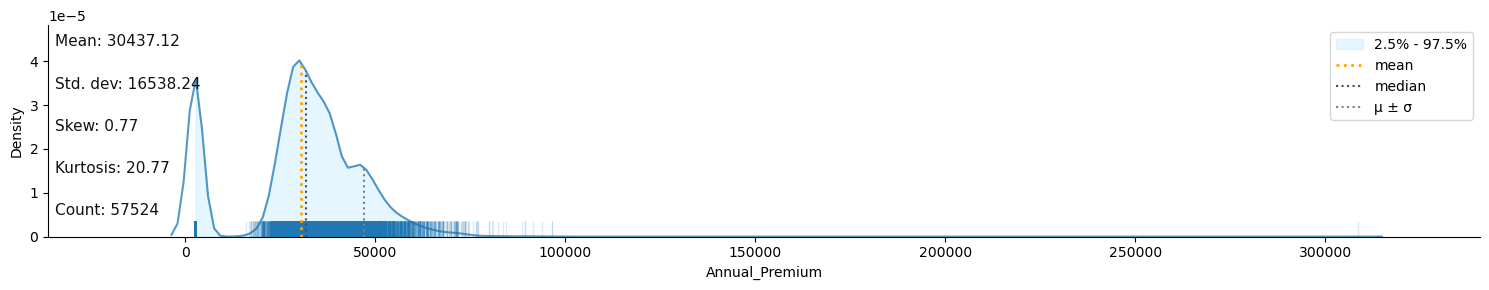

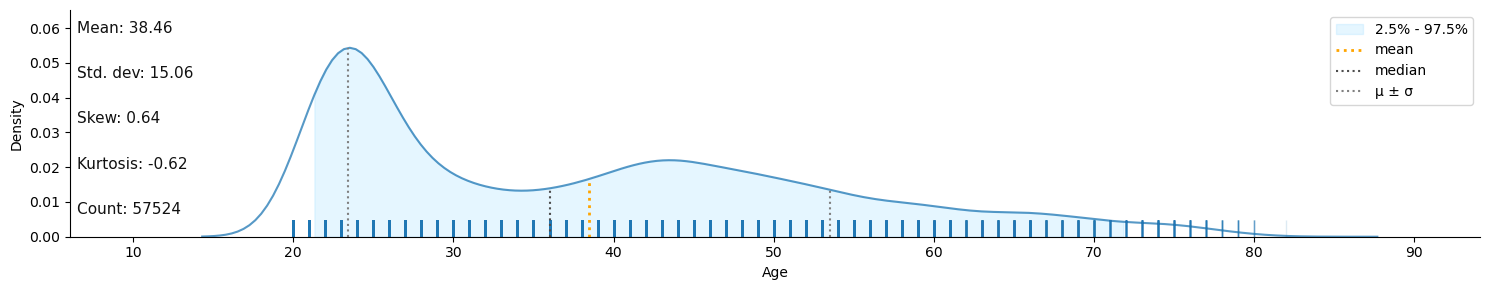

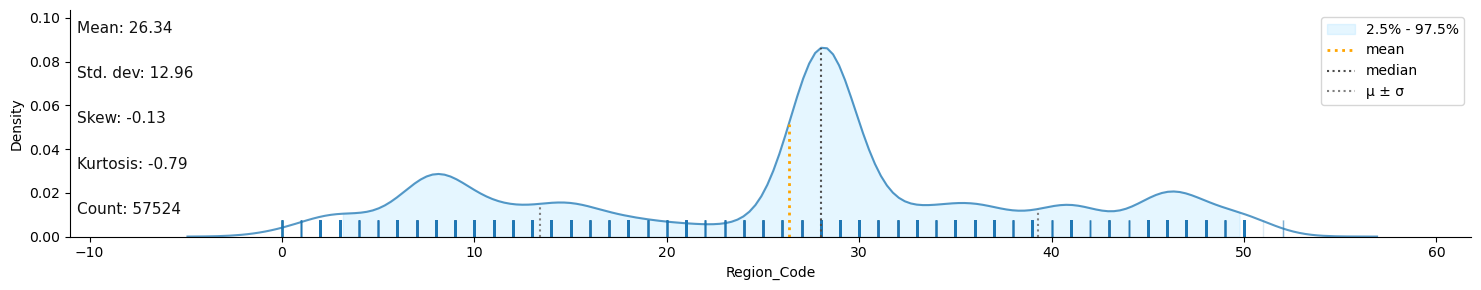

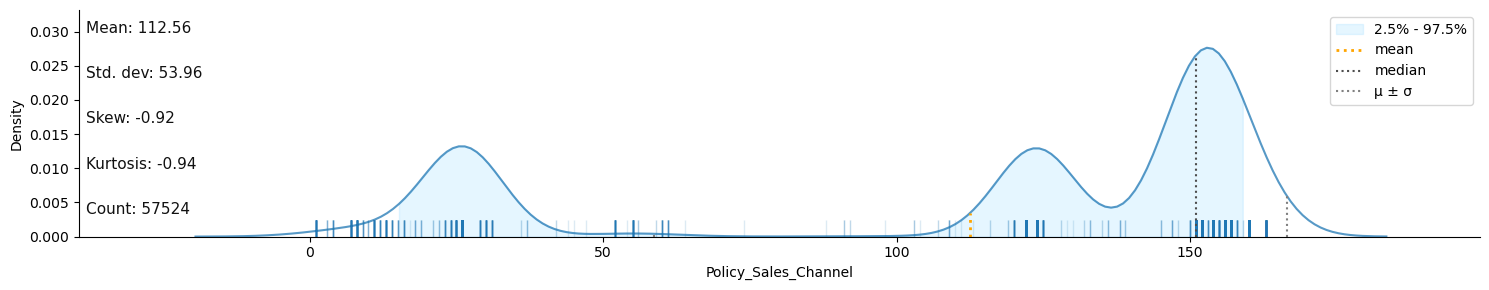

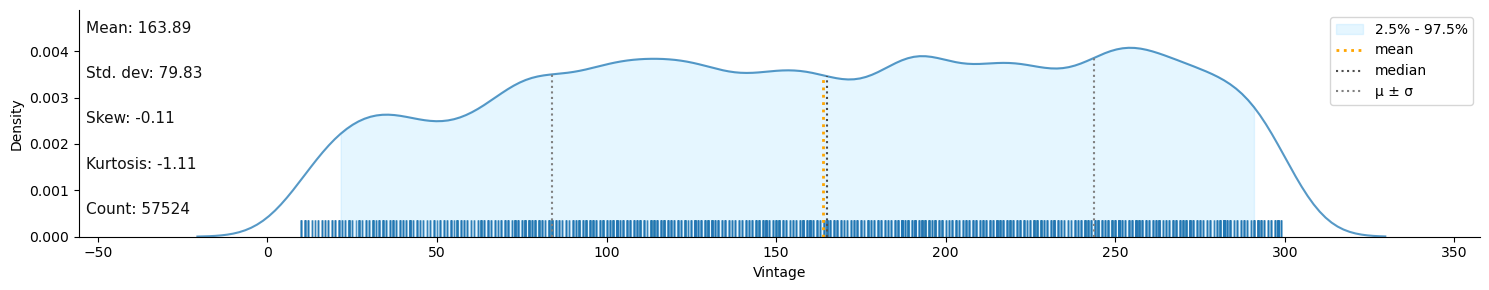

In [15]:
# Plotting categorical features against the target variable
klib.dist_plot(eda_df[['Annual_Premium']])
klib.dist_plot(eda_df[['Age']])
klib.dist_plot(eda_df[['Region_Code']])
klib.dist_plot(eda_df[['Policy_Sales_Channel']])
klib.dist_plot(eda_df[['Vintage']])

### Distribution Plot Analysis
- **Annual_Premium** is heavily right-skewed with some heavy outliers in larger numbers. It is also bimodally distributed with a large concentration in the lower values and a second concentration near the mean. I might use a standard outlier removal method or a more aggressive quartile method. It might also benefit from log-transformation for its skewness.
- **Age** is right-skewed, but given the nature of the feature, I will leave it as is and use only a MinMax Scaler during preprocessing.
- **Region_Code** is actually a category but has many different values. It is clear certain regions are much more favored. In a previous notebook, I tried compiling all of the rarer codes into their own category. I might attempt this again but will need to consider that the rare category must be a number in itself for the model.
- **Policy_Sales_Channel** is similar to Region_Code and will be treated the same way.
- **Vintage** is the most normally distributed feature and I will probably scale it with a MinMax Scaler.

### Encoding Categorical Features

Here, we encode the 'Previously_Insured' feature. So that it works properly with the klib correlation plot.

In [16]:
eda_df['Previously_Insured'] = eda_df['Previously_Insured'].cat.codes

### Correlation Plot with KLIB
We use KLIB to create a correlation plot to identify relationships between the features and the target variable. This helps in understanding which features might be important for the model.


<Axes: title={'center': 'Feature-correlation (pearson)'}>

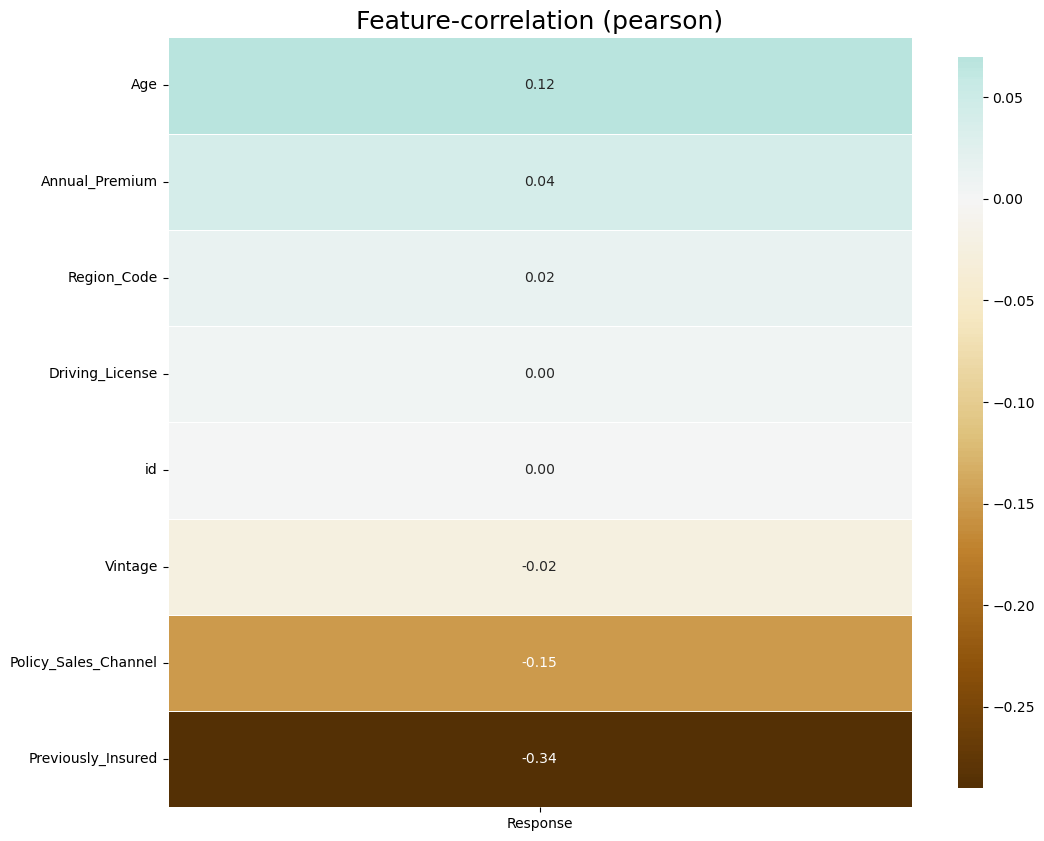

In [17]:
klib.corr_plot(eda_df, target='Response')

### Correlation Plot Analysis
The only feature that seems to have a significant relation towards conversion on the target is whether people are uninsured prior to the call. Based on this I will borrow the features that were engineered in another notebook to create categorical features that capture the relationship between other features and 'Previously_Insured'.

##### Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution

In [18]:
del eda_df

## Custom Functions

In this section, we define custom functions to streamline our data processing and feature engineering tasks. These functions help in optimizing memory usage, handling categorical features, and generating new features from existing ones. Let's walk through each of them.

### Memory Optimization Function

Efficient memory usage is crucial when dealing with large datasets. The `reduce_mem_usage` function iterates through all columns of a dataframe and modifies their data type to reduce memory consumption. This optimization ensures that we can handle the dataset more effectively without running into memory issues.

### Safe Mapping Function

Handling categorical features often involves mapping them to numerical values. The `safe_map` function ensures that we map these categories correctly and log any unknown categories that might be encountered during the process.

### Feature Engineering Function

Feature engineering is a critical step in enhancing model performance. The `feature_engineering` function creates new features by combining existing ones. These new features capture interactions between variables that might be predictive of the target variable.
We create new features by capturing the interactions between them and encoding that into categorical combinations. This can provide additional information to the model and improve its performance.
##### Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
https://www.kaggle.com/code/khangtran94vn/khang-eda-classification-insurance/notebook

In [19]:
def import_data(path, index_col=None):
    """Import data from a CSV file and optimize memory usage."""
    df = pd.read_csv(path, index_col=index_col)
    return reduce_mem_usage(df)

def reduce_mem_usage(df):
    """Iterate through all the columns of a dataframe and modify the data type to reduce memory usage."""
    for col in df.columns:
        col_type = df[col].dtype
        if isinstance(col_type, pd.IntervalDtype):
            continue

        if str(col_type)[:3] == 'int':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        elif str(col_type)[:5] == 'float':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    return df

def feature_engineering(df):
    """Feature engineering on the dataset."""
    # Binning age and converting to categorical labels instead of intervals
    age_bins = pd.cut(df['Age'], bins=7, labels=False)
    df['Age_Type'] = age_bins
    df['Vehicle_Age'] = df['Vehicle_Age'].astype('category').cat.codes
    df['Vehicle_Damage'] = df['Vehicle_Damage'].astype('category').cat.codes
    df['Previously_Insured'] = df['Previously_Insured'].astype('category').cat.codes

    df['Age_x_Vehicle_Age'] = df['Age_Type'] * df['Vehicle_Age']
    df['Age_x_Vehicle_Damage'] = df['Age_Type'] * df['Vehicle_Damage']
    df['Age_x_Previously_Insured'] = df['Age_Type'] * df['Previously_Insured']

    fac_pre = ['Policy_Sales_Channel', 'Vehicle_Damage', 'Annual_Premium', 'Vintage', 'Age_Type']
    col_pre = []
    for i in fac_pre:
        df['Previously_Insured_x_' + i] = pd.factorize(df['Previously_Insured'].astype(str) + df[i].astype(str))[0]
        col_pre.append('Previously_Insured_x_' + i)

    fac_pro = fac_pre[1:]
    col_pro = []
    for i in fac_pro:
        df['Policy_Sales_Channel_x_' + i] = pd.factorize(df['Policy_Sales_Channel'].astype(str) + df[i].astype(str))[0]
        col_pro.append('Policy_Sales_Channel_x_' + i)
    return df, col_pre, col_pro

def reduce_mem_usage_np(array):
    """Reduce memory usage of a numpy array by converting its dtype without losing significant precision."""
    for col in range(array.shape[1]):
        col_data = array[:, col]
        if np.issubdtype(col_data.dtype, np.floating):
            col_min = col_data.min()
            col_max = col_data.max()
            if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                array[:, col] = col_data.astype(np.float16)
            elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                array[:, col] = col_data.astype(np.float32)
        elif np.issubdtype(col_data.dtype, np.integer):
            col_min = col_data.min()
            col_max = col_data.max()
            if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                array[:, col] = col_data.astype(np.int8)
            elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                array[:, col] = col_data.astype(np.int16)
            elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                array[:, col] = col_data.astype(np.int32)
    return array

## Combining Datasets
We combine the datasets for the feature engineering step and seperate them again after to avoid any data leakage, but the transformations themselves to the data are applied seperately to avoid outliers distorting the test set.

In [20]:
# Load and optimize data
train_df = import_data(train_path, index_col='id')
test_df = import_data(test_path, index_col='id')

# train_df = train_df.sample(frac=0.005)
# test_df = test_df.sample(frac=0.005)

# Combine train and test datasets for consistent transformation
full_df = pd.concat([train_df, test_df], axis=0)

In [21]:
# Convert columns to category type
less = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
for col in less:
    full_df[col] = full_df[col].astype('category')

# Apply feature engineering to the combined dataset
full_df, col_pre, col_pro = feature_engineering(full_df)

In [22]:
# Split back into train and test sets
train_df = full_df.iloc[:len(train_df), :]
test_df = full_df.iloc[len(train_df):, :]

# Split the training data into training and validation sets
X = train_df.drop('Response', axis=1)
y = train_df['Response']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [23]:
# Define the ColumnTransformer
coltrans = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, dtype=np.float32), ['Gender', 'Vehicle_Damage']),
        ('minmax', MinMaxScaler(), ['Age', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel', 'Vintage']),
        ('ordinal', OrdinalEncoder(categories=[[0, 1, 2]], dtype=np.float32), ['Vehicle_Age']),
        ('robust', RobustScaler(), ['Annual_Premium']),
        ('standard', StandardScaler(), ['Age_Type', 'Age_x_Vehicle_Age', 'Age_x_Vehicle_Damage', 'Age_x_Previously_Insured']),
        ('standard_2', StandardScaler(), col_pre + col_pro),
    ],
    remainder='passthrough'  # Keeps columns not specified in transformers
)

# Fit the transformer on the training data and transform both training and validation sets
X_train = coltrans.fit_transform(X_train)
X_valid = coltrans.transform(X_valid)
test_df = coltrans.transform(test_df.drop('Response', axis=1))

# Reduce memory usage of transformed data
X_train = reduce_mem_usage_np(X_train)
X_valid = reduce_mem_usage_np(X_valid)
test_df = reduce_mem_usage_np(test_df)

gc.collect()

9334

## Model Training and Evaluation
In this section, we train our model using LightGBM, XGBoost, and CatBoost, and blend their predictions.

## Modeling Process

For this competition, I selected CatBoost, LightGBM, and XGBoost. Each model has unique strengths, making them ideal for capturing different aspects of the data. Blending their predictions leverages these strengths for a more robust solution. Because of the massive size of the dataset I'm saving each model iteration created by each fold, in case something goes wrong during modeling.

- **CatBoost:** Excels with categorical variables.
- **LightGBM:** Offers speed and efficiency.
- **XGBoost:** Ensures versatility and robustness.

Most of these values for hyperparameters are based on previous searches using OPTUNA or referencing other notebooks from the competition.

Reference: https://www.kaggle.com/code/darkdevil18/0-89698-ps4e7-are-you-insured

In [24]:
# Calculate the ratio for scale_pos_weight
ratio = len(train_df[train_df['Response'] == 0]) / len(train_df[train_df['Response'] == 1])
class_weights = {0: 1, 1: ratio}

## CatBoost

- **Handles Categorical Data Natively:** Reduces preprocessing needs.
- **Ordered Boosting:** Minimizes overfitting and improves generalization.

In [25]:
# # Define CatBoost parameters
# cat_params = {
#     'loss_function': 'Logloss',
#     'eval_metric': 'AUC',
#     'class_names': [0, 1],
#     'learning_rate': 0.05,
#     'iterations': 10000,
#     'depth': 9,
#     'bagging_temperature': 0.017138393608280057,
#     'random_strength': 9.256288011643901,
#     'max_bin': 404,
#     'l2_leaf_reg': 55.37964307854247,
#     'task_type': 'GPU',  
#     'allow_writing_files': False,
#     'verbose': 500,
#     'class_weights': class_weights,
#     'max_leaves': 512,
#     'fold_permutation_block': 64,
#     #'thread_count': -1
# }

# test_pool = Pool(test_df)
# train_pool = Pool(X_train, y_train)
# valid_pool = Pool(X_valid, y_valid)

# cbc = CatBoostClassifier(**cat_params)
# cbc.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=1000)

# test_pred_cbc = cbc.predict_proba(test_pool)[:, 1]

# del cbc, test_pool, train_pool, valid_pool

# gc.collect()

## LightGBM

- **Histogram-Based Algorithms:** Efficient training and memory usage.
- **Leaf-Wise Growth:** Reduces loss more aggressively, enhancing accuracy.

In [26]:
# # Define LightGBM parameters
# lgb_params = {
#                'max_depth': 6,
#                "metric": "auc",
#                "early_stopping_round": 50,
#                "max_bin": 255,
#                'num_leaves': 223,
#                'learning_rate': 0.028095688623590447,
#                'min_child_samples': 54,
#                'subsample': 0.5395472919165504,
#                'colsample_bytree': 0.547518064129546,
#                'lambda_l1': 3.4444245446562,
#                'lambda_l2': 2.87490408088595e-05,
#                'scale_pos_weight': ratio,
#                'early_stopping_rounds': 10,
#                'device': 'gpu',
#                'verbose': -1,
# #                'n_jobs': -1
# }

# # Train LightGBM model
# train_data = lgb.Dataset(X_train, label=y_train)
# valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)


# lgb = lgb.train(
#     lgb_params,
#     train_data,
#     num_boost_round=2000,
#     valid_sets=[train_data, valid_data],
# )

# test_pred_lgb = lgb.predict(test_df, num_iteration=lgb.best_iteration)

# del lgb, train_data, valid_data

# gc.collect()

## XGBoost

- **Regularization (L1 and L2):** Prevents overfitting, improving robustness.
- **Tree Pruning:** Effectively manages overfitting.
- **Parallel Processing:** Speeds up training on large datasets.

In [27]:
# Define XGBoost parameters
xgb_params = {
    'random_state': 512,
    'objective': "binary:logistic",
    'eval_metric': 'auc',
    'max_depth': 8,
    'min_child_weight': 12,
    'colsample_bytree': 0.5,
    'gamma': 0.2,
    'learning_rate': 0.09093568107192034,
    'subsample': 1.0,
    'reg_alpha': 0.0011852827097616767,
    'reg_lambda': 1.0735757602378362e-06,
    'max_bin': 262143,
    'scale_pos_weight': ratio,  # Adjust this based on your dataset
    'tree_method': 'gpu_hist',  # Ensure your environment supports GPU
    'device': 'cuda',  # Ensure your environment supports GPU
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=10000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        verbose_eval=500,
        early_stopping_rounds=100,
    )

dtest = xgb.DMatrix(test_df)
test_pred_xgb = model.predict(dtest, iteration_range=(0, model.best_iteration))

del model, dtrain, dvalid, dtest

gc.collect()

[0]	train-auc:0.85641	valid-auc:0.85623
[500]	train-auc:0.89007	valid-auc:0.88558
[1000]	train-auc:0.89590	valid-auc:0.88788
[1500]	train-auc:0.89997	valid-auc:0.88895
[2000]	train-auc:0.90293	valid-auc:0.88950
[2500]	train-auc:0.90554	valid-auc:0.88976
[3000]	train-auc:0.90788	valid-auc:0.89002
[3065]	train-auc:0.90788	valid-auc:0.89002


67663

## Blending Predictions
We blend predictions from CatBoost, LightGBM, and XGBoost models to create the final submission.

In [28]:
# # Blending predictions with calculated weights
# blended_preds = (test_pred_cbc + test_pred_xgb)/2

# Reimport the test_df to get the original index
test_df = import_data(test_path, index_col='id')

# Create a submission DataFrame using the original test index
submission = pd.DataFrame({
    'id': test_df.index,
    'Response': test_pred_xgb
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

## What We Did in This Notebook

This notebook showcased a detailed and comprehensive end-to-end workflow for tackling the Kaggle Playground Series S4E07 competition. Here’s a recap of our journey:

### Exploratory Data Analysis (EDA)
- **Initial Explorations:** We kicked off with a subset of the data to get a quick grasp of its structure and nuances. This initial dive helped us spot potential issues and interesting patterns early on.
- **KLIB Visualizations:** We utilized KLIB for streamlined visualizations and correlation analysis, making it easier to pinpoint key features and understand their relationships with the target variable.

### Data Preprocessing
- **Handling Missing Values:** We meticulously checked for missing values to ensure data integrity throughout the modeling process.
- **Categorical Encoding:** By converting categorical variables into numerical formats, we prepped the data for machine learning models.
- **Memory Optimization:** To efficiently handle the large dataset, we optimized memory usage through downcasting of data types.

### Feature Engineering
- **Creating New Features:** We got creative with feature engineering, developing new features by combining existing ones. This allowed us to capture interactions between variables that could boost model performance.
- **Scaling Numerical Features:** Standard scaling was applied to numerical features to bring them onto a similar scale, which is essential for many machine learning algorithms to perform optimally.

### Modeling and Evaluation
- **Model Selection:** We chose three powerhouse models – CatBoost, LightGBM, and XGBoost – each known for its unique strengths in handling structured data.
- **Cross-Validation:** To get a reliable estimate of model performance, we used stratified k-fold cross-validation, ensuring our models were tested across diverse subsets of the data.
- **Hyperparameter Tuning:** Leveraging Optuna, we efficiently tuned the hyperparameters, squeezing out the best performance from our models.

### Blending Predictions
- **Ensemble Approach:** Instead of relying on a single model, we blended predictions from CatBoost, LightGBM, and XGBoost based on their ROC-AUC scores. This ensemble method harnessed the strengths of each model, resulting in superior overall performance.